In [1]:
import multiprocessing
import os
import time
import numpy as np
from scipy.spatial import cKDTree
import open3d as o3d
import util
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from BendLength import BendLengthCalculator

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
point_cloud_location = "/home/chris/Code/PointClouds/data/ply/CircularVentilationGrateExtraCleanedFull.ply"
pcd = o3d.io.read_point_cloud(point_cloud_location)

In [3]:
# Preprocess the point cloud
pcd = util.preProcessCloud(pcd)
pcd_points = np.asarray(pcd.points)

# Detect planes, intersections, and anchor points
segment_models, segments, main_surface_idx = util.multiOrderRansac(pcd, pt_to_plane_dist=0.4)
all_normals, pointwise_variance = util.calculatePointwiseNormalVariance(pcd, radius=2)

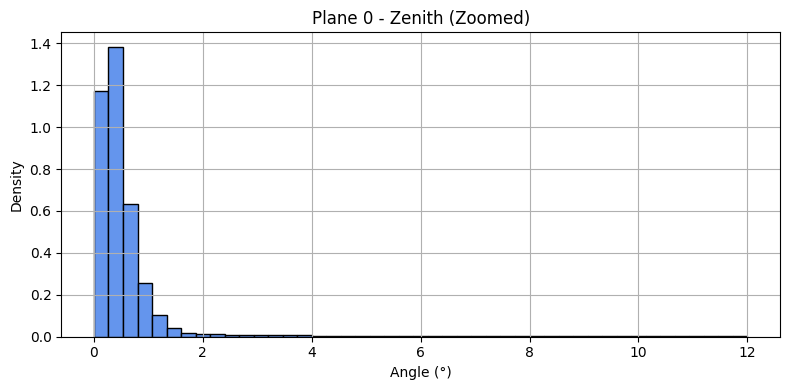

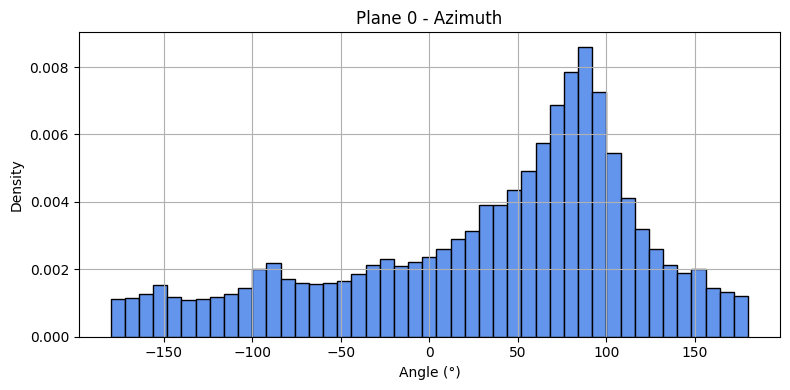

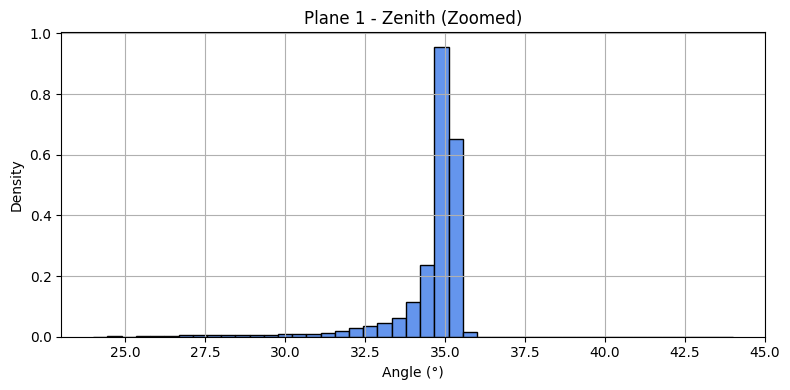

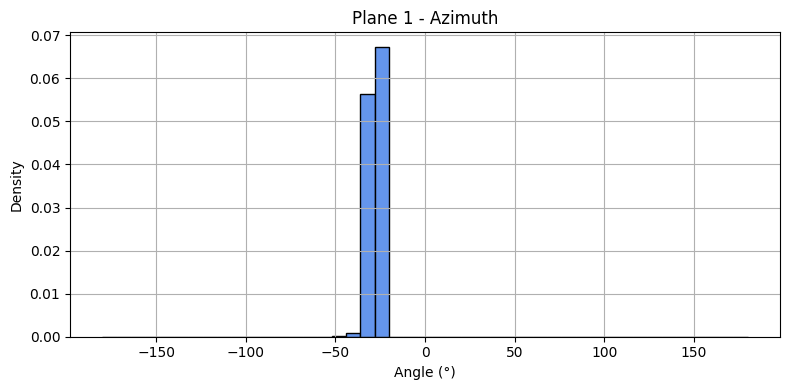

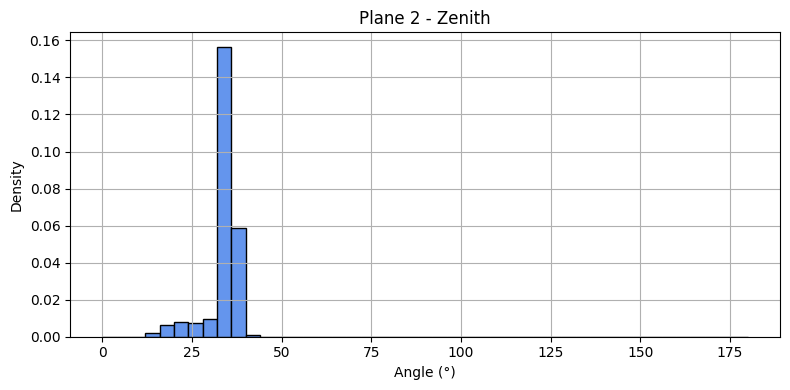

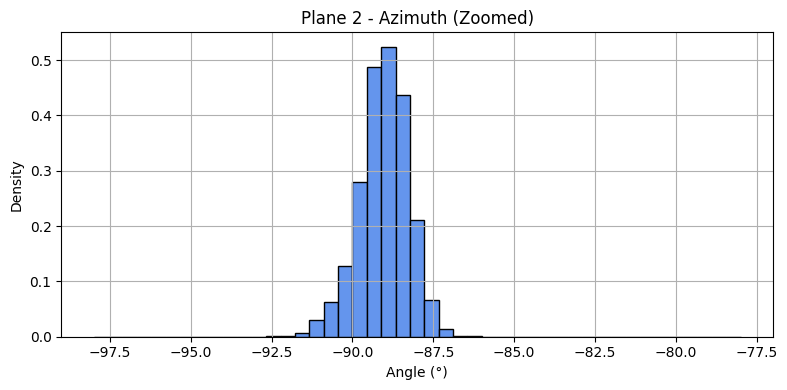

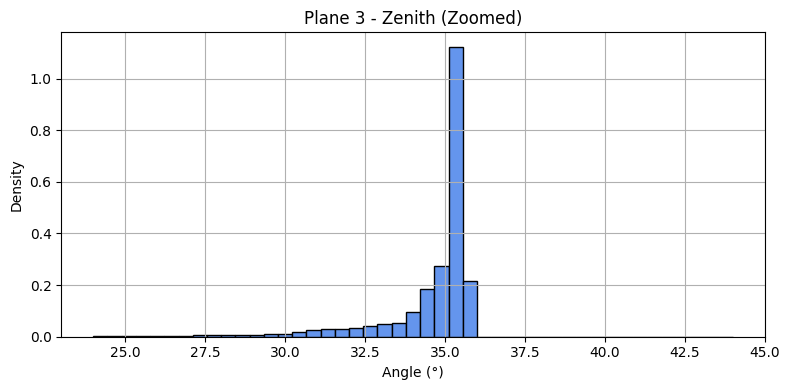

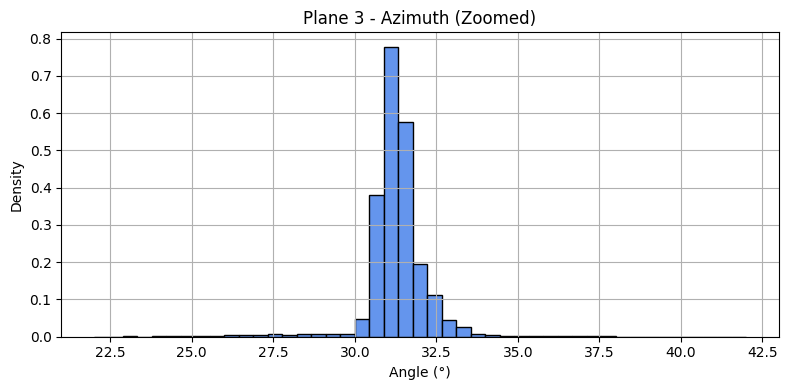

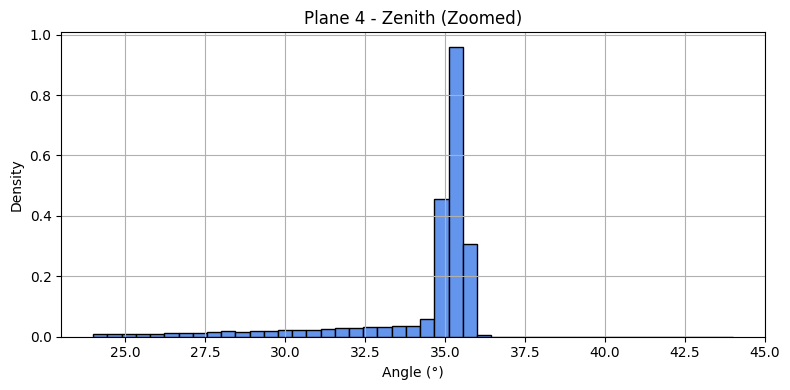

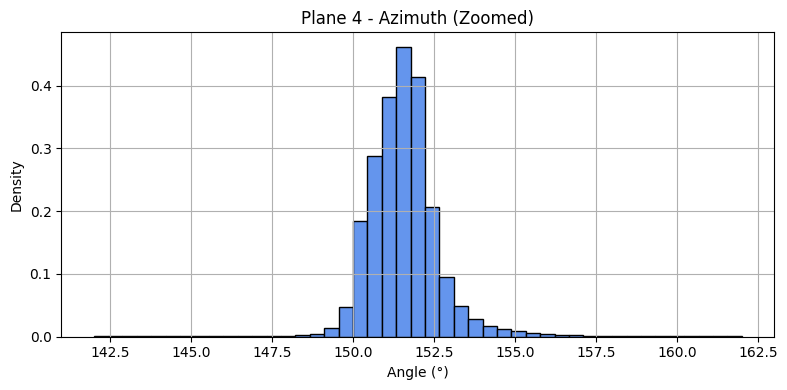

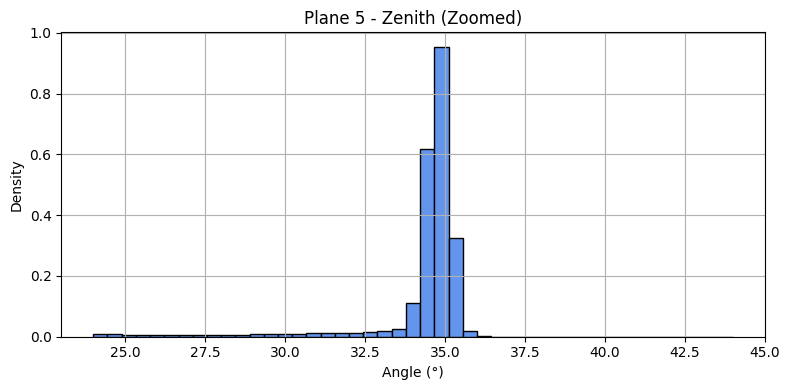

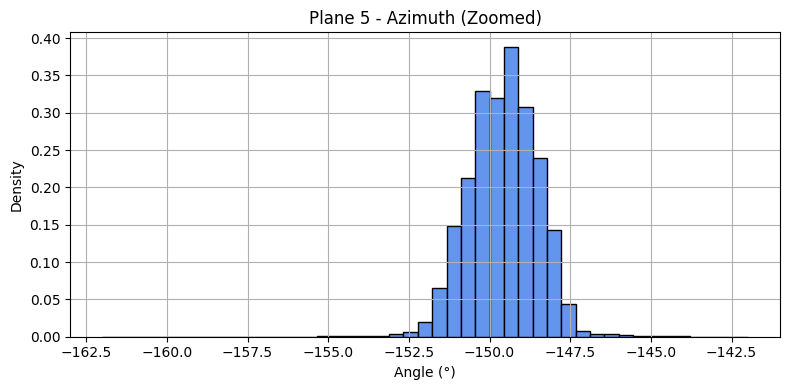

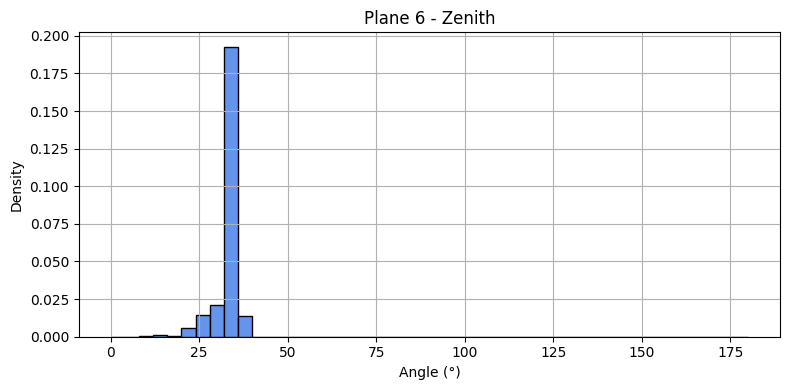

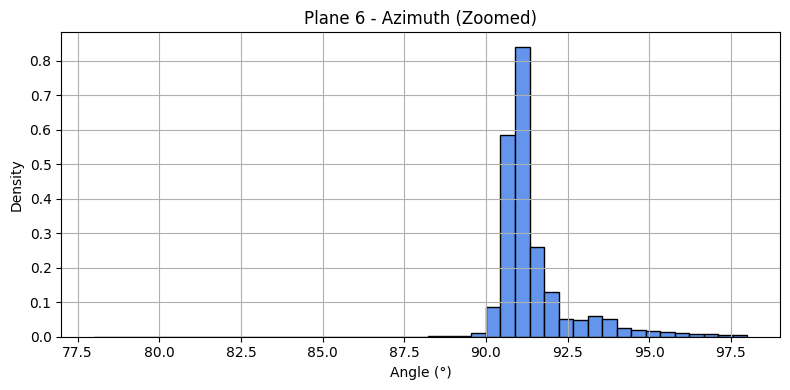

In [4]:
def compute_azimuth_zenith(normals):
    """Compute azimuth and zenith angles from normals."""
    azimuth = np.arctan2(normals[:, 1], normals[:, 0])  # [-π, π]
    zenith = np.arccos(normals[:, 2])  # [0, π]
    return np.degrees(azimuth), np.degrees(zenith)

def dynamic_histogram(values, title, angle_range, num_bins=45, zoom_threshold=0.8):
    counts, bin_edges = np.histogram(values, bins=num_bins, range=angle_range)
    max_bin_count = counts.max()
    total = len(values)

    # Check if most values are in a single bin
    if max_bin_count / total > zoom_threshold:
        max_bin_index = np.argmax(counts)
        center = 0.5 * (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1])
        zoom_range = (center - 10, center + 10)  # ±10° around the peak
        zoom_range = (
            max(zoom_range[0], angle_range[0]),
            min(zoom_range[1], angle_range[1])
        )
    else:
        zoom_range = angle_range

    # Plot
    plt.figure(figsize=(8, 4))
    plt.hist(values, bins=num_bins, range=zoom_range, color='cornflowerblue', edgecolor='black', density=True)
    plt.title(f"{title} (Zoomed)" if zoom_range != angle_range else title)
    plt.xlabel("Angle (°)")
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage for each plane:
for plane_idx, segment in segments.items():
    indices = np.asarray(segment.points)
    mask = np.isin(pcd_points, indices).all(axis=1)
    plane_normals = all_normals[mask]

    if len(plane_normals) == 0:
        continue

    azimuth, zenith = compute_azimuth_zenith(plane_normals)

    dynamic_histogram(zenith, f"Plane {plane_idx} - Zenith", angle_range=(0, 180))
    dynamic_histogram(azimuth, f"Plane {plane_idx} - Azimuth", angle_range=(-180, 180))
